- https://nbviewer.org/github/sktime/sktime/blob/4194aacaa105ef59807ea56c1bb3497b37eb1613/examples/01_forecasting.ipynb
- https://sites.google.com/site/nttrungmtwiki/home/it/data-mining/time-series-analysis/time-series-forecasting-performance-metrics-comparison

# Overview
The famous ARIMA is nothing but a Linear Regression model on lags. So what if we replace naive Linear Regression with a state-of-the-art tabular learning algorithm? This is what being implemented in [Skforecast], a library uses any regression algorithm follows Scikit-learn interface to make multi-step forecast to a time series.

[Skforecast](https://joaquinamatrodrigo.github.io/skforecast/0.4.3/quick-start/introduction-forecasting.html) uses sklearn regressors to forecast multi-step time series. It also works with any regressor compatible with the scikit-learn API (pipeline, Xgboost, catboost,..). 

Since single-value forecasting is used to predict only the next value of the series $t+1$. This process can be done with 5 algorithms above. Skforecast is dedicated to forecast multi-value timeseries. 

Skforecast treats exog variables like knowing future values, otherwise the series still are time-series and they need to predict in multi-time series forecast module. With exogenous variables, whose the future values are known (such as date, hour, holiday,..), could serve as additional predictors in the model. 

[Skforecast]: https://joaquinamatrodrigo.github.io/skforecast/0.5.1

# 1. Regressor wrappers

## 1.1. Recursive forecast
Since the value $t_{n-1}$ is required to predict $t_n$. A recursive process is applied to predict each $t_{n}$ - based on the previous one. *This process only needs to train 1 model with different input at each step* and can be easily generated with the 
<code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/api/ForecasterAutoreg.html'>ForecasterAutoreg</a></code>
class and
<code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/api/ForecasterAutoregCustom.html'>ForecasterAutoregCustom</a></code> class.

In [12]:
import numpy as np
import pandas as pd
import janitor

import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

import warnings; warnings.filterwarnings('ignore')

# hide progress bar
from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [17]:
dfTemp = pd.read_csv('data/air_quality.csv')
dfTemp = (
    dfTemp
    .to_datetime('time')
    .select_columns(['time', 'temp', 'rel_humidity', 'abs_humidity'])
    .set_index('time')
    .asfreq('h')
)
dfTemp.head()

,temp,rel_humidity,abs_humidity
time,,,
2004-03-10 18:00:00,13.6,48.9,0.7578
2004-03-10 19:00:00,13.3,47.7,0.7255
2004-03-10 20:00:00,11.9,54.0,0.7502
2004-03-10 21:00:00,11.0,60.0,0.7867
2004-03-10 22:00:00,11.2,59.6,0.7888


In [3]:
dfTemp = pd.read_excel('data/AirQuality.xlsx')

dfTemp['datetime'] = pd.to_datetime(dfTemp.date.astype(str)+' '+dfTemp.time.astype(str))
dfTemp = dfTemp[['datetime','temp','relativeHumidity','absoluteHumidity']]\
.set_index('datetime').asfreq('h')

<AxesSubplot:xlabel='datetime'>

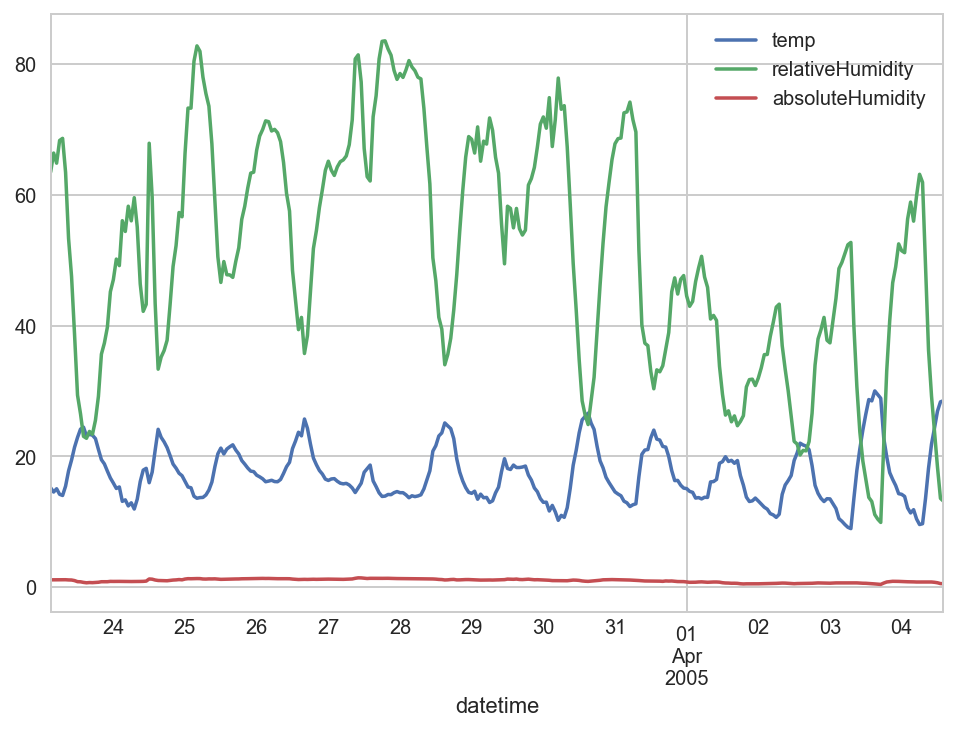

In [4]:
dfTemp.tail(300).plot()

In [5]:
obs = 9000
train = dfTemp[:obs]
test = dfTemp[obs:]

In [6]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=7),
    lags = 24
)

forecaster.fit(y=train.temp, exog=train[['relativeHumidity','absoluteHumidity']])

In [6]:
steps = len(test)
predictions = forecaster.predict_interval(steps=steps, exog=test[['relativeHumidity','absoluteHumidity']])
predictions.head(5)

,pred,lower_bound,upper_bound
2005-03-20 18:00:00,20.446667,20.053858,20.960917
2005-03-20 19:00:00,18.891667,18.242196,19.903304
2005-03-20 20:00:00,17.743750,16.999413,18.890304
2005-03-20 21:00:00,16.800500,16.072500,18.018383
2005-03-20 22:00:00,16.126583,15.289458,17.205954


In [7]:
forecaster.get_feature_importance().tail(5)

,feature,importance
21,lag_22,0.000140
22,lag_23,0.000190
23,lag_24,0.000056
24,relativeHumidity,0.508992
25,absoluteHumidity,0.451340


In [8]:
def plot_prediction(y_true, pred_interval):
    mse = mean_squared_error(y_true, pred_interval.pred)
    fig, ax = plt.subplots(figsize=(12, 6))
    y_true.plot(label='test', ax=ax)
    pred_interval.pred.plot(label='prediction', ax=ax)
    ax.fill_between(
        pred_interval.index,
        pred_interval.lower_bound,
        pred_interval.upper_bound,
        alpha = 0.2,
        color = 'grey',
        label = 'prediction interval' 
    )
    ax.legend()
    plt.show()
    return print("MSE: ",mse)

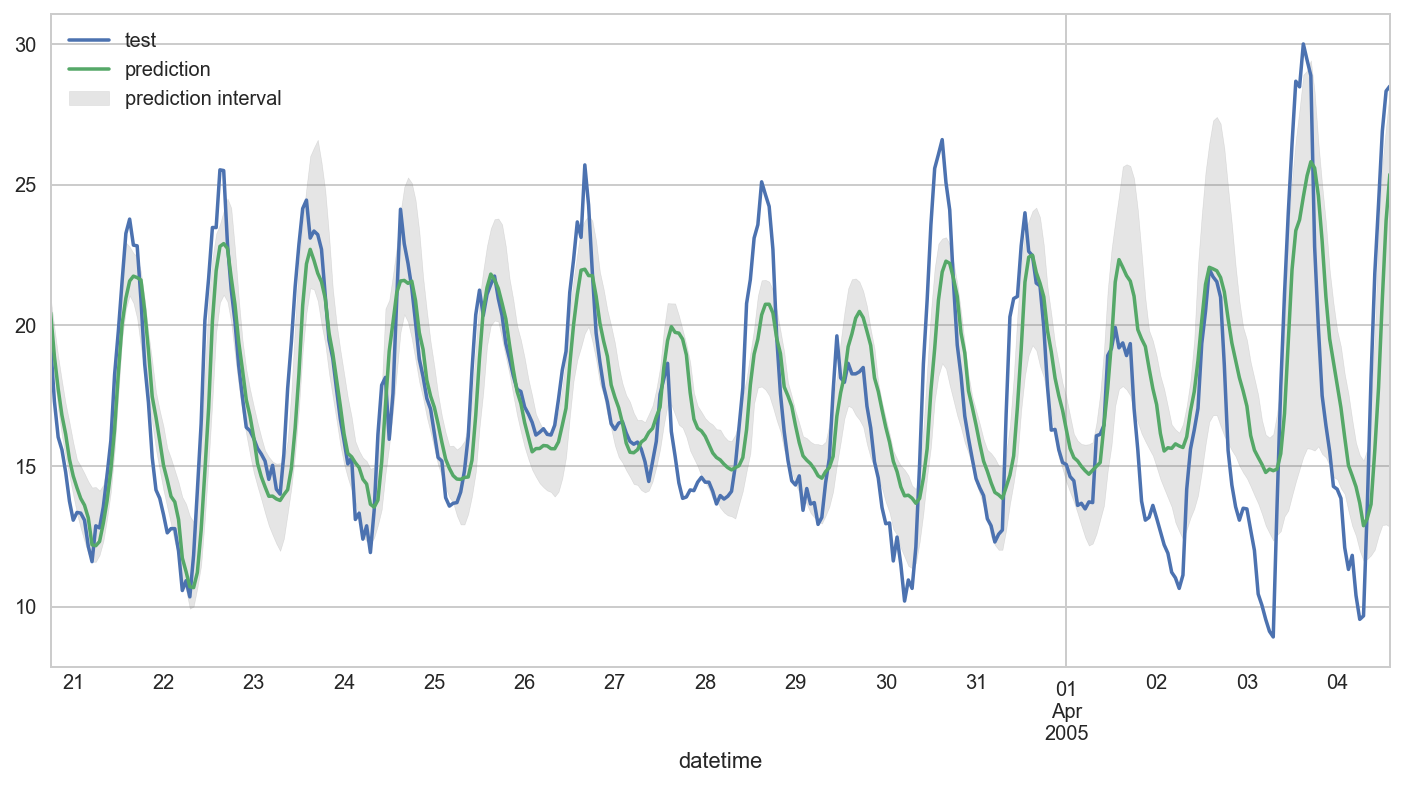

MSE:  7.0265967919844945


In [9]:
plot_prediction(test.temp, predictions)

## 1.2. Direct forecast
*Direct process uses different  models to train the same input at each step*, the predictions are independent of each other. This process is computationally more expensive than recursive since it requires training several models and it's automated in the <code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/ForecasterAutoregDirect.html'>ForecasterAutoregDirect</a></code> class

In [8]:
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries 
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect 

In [9]:
dfTemp = pd.read_excel('data/AirQuality.xlsx')

dfTemp['datetime'] = pd.to_datetime(dfTemp.date.astype(str)+' '+dfTemp.time.astype(str))
dfTemp = dfTemp[['datetime','temp','relativeHumidity','absoluteHumidity']]\
.set_index('datetime').asfreq('h')

obs = 9000
train = dfTemp[:obs]
test = dfTemp[obs:]

In [11]:
steps = len(test)
forecaster = ForecasterAutoregDirect(
                regressor = LGBMRegressor(max_depth=4),
                steps     = steps,
                lags      = 24
             )
forecaster.fit(
    train.temp,
    # exog=train[['relativeHumidity','absoluteHumidity']],
)

MSE:  96.3706234229148


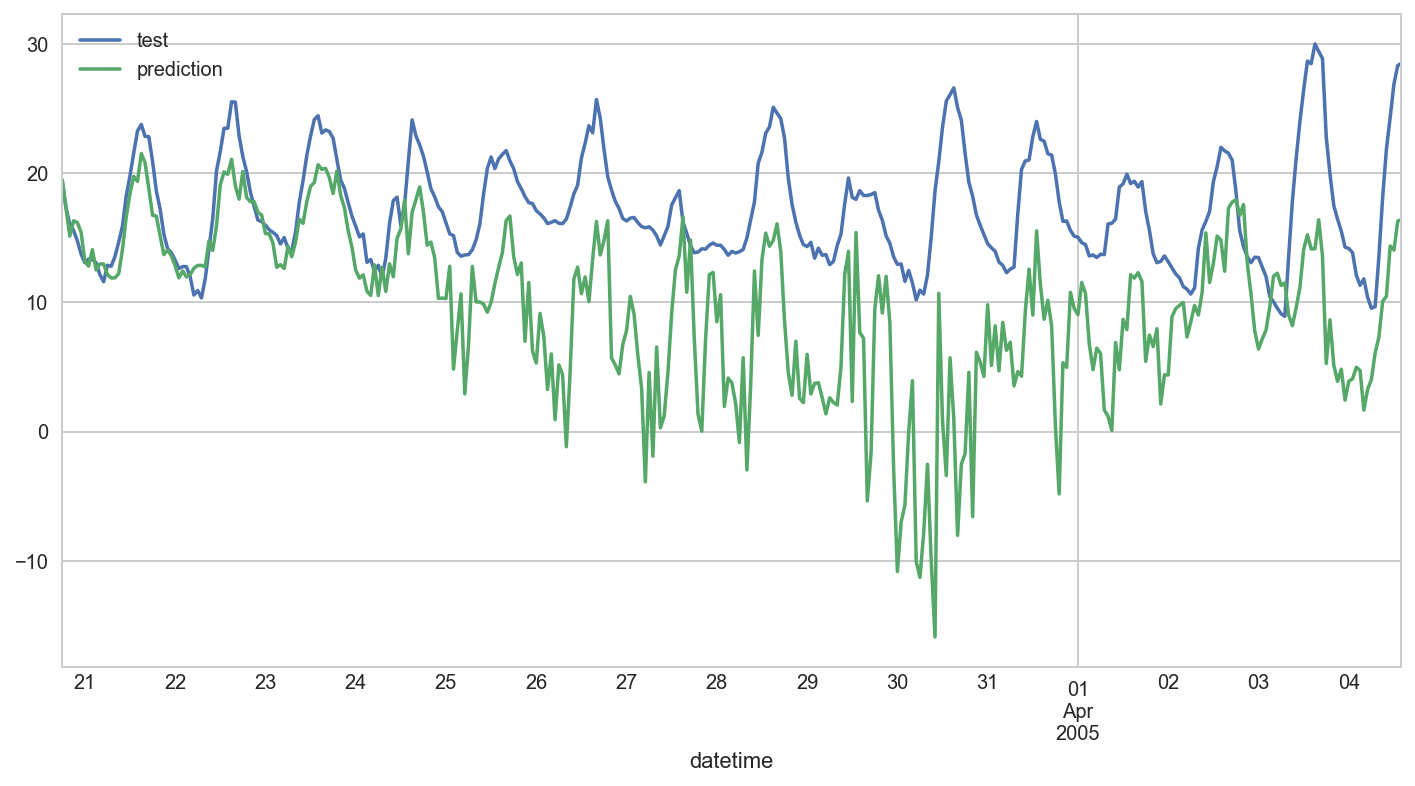

In [12]:
pred = forecaster.predict(
    steps=steps,
    # exog=test[['relativeHumidity','absoluteHumidity']]
)
mse = mean_squared_error(test.temp, pred)
print('MSE: ',mse)

fig, ax = plt.subplots(figsize=(12, 6))
test.temp.plot(label='test', ax=ax)
pred.plot(label='prediction', ax=ax)
ax.legend()
plt.show()

## 1.3. Multi-label forecast

In [multi-time series](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/user_guides/multi-time-series-forecasting.html) forecasting, two or more time series are modeled together using a single model. Two strategies can be distinguished:

- No-multivariate time series: Used for independent multi series has the same pattern, which means a single model is trained and each predictor is applied independently to others. This process is wrapped in  <code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/ForecasterMultiSeries.html'>ForecasterAutoregMultiSeries</a></code> class

- Multivariate time series: All series are modeled in a single model considering that each time series depends not only on its past values but also on the past values of the other series. This process is developing

In [52]:
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries

In [53]:
dfTemp = pd.read_excel('data/AirQuality.xlsx')

dfTemp['datetime'] = pd.to_datetime(dfTemp.date.astype(str)+' '+dfTemp.time.astype(str))
dfTemp = dfTemp[['datetime','temp','relativeHumidity','absoluteHumidity']]\
.set_index('datetime').asfreq('h')

obs = 9000
train = dfTemp[:obs]
test = dfTemp[obs:]

In [56]:
steps = len(test)
forecaster = ForecasterAutoregMultiSeries(
                regressor = LGBMRegressor(max_depth=4),
                lags      = 24
             )
forecaster.fit(series=train[['temp','relativeHumidity']])

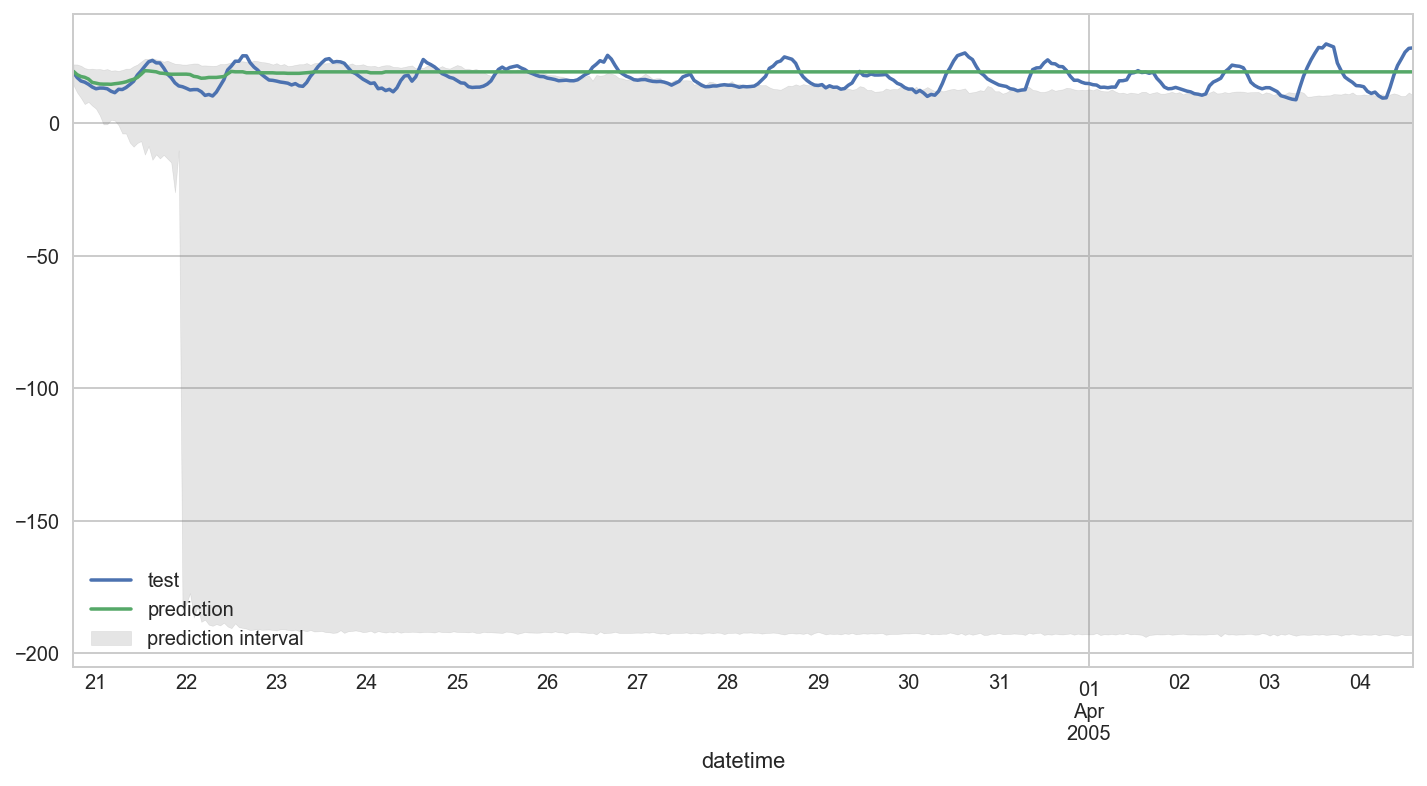

MSE:  21.07075038816796


In [61]:
pred_interval = forecaster.predict_interval(steps=steps,level='temp')

plot_prediction(test.temp, pred_interval)

# 2. Forecasting validation

## 2.1. Metrics
- https://www.sktime.org/en/stable/api_reference/performance_metrics.html
- https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
- https://www.relexsolutions.com/resources/measuring-forecast-accuracy/

### Regression metrics
R2, RMSE, MSE, MAE

### Percentage-error metrics
https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_percentage_error.html

### Scaled error metrics
https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.mean_absolute_scaled_error.html#

### Relative-error metrics

## 2.2. Backtesting 

[Backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/quick-start/introduction-forecasting.html#backtesting-forecasting-models) is a special type of cross-validation which involves moving backward in time step-by-step. Function <code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.backtesting_forecaster'>backtesting_forecaster</a></code> wrapped 3 types of backtest through 2 params  `fixed_train_size` and `refit`:
- Backtesting with refit and increasing training size (fixed origin): The model is trained each time before making predictions, the test size is fixed and the training set increases sequentially. 
- Backtesting with refit and fixed training size (rolling origin): Both the training and testing set rolls forward, therefore, the size of training remains constant. 
- Backtesting without refit: The model is trained only once and not updating sequentially.Thus, this strategy has the advantage of being much faster. However, the model does not incorporate the latest information available, so it may lose predictive capacity over time.

In [65]:
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals

In [63]:
dfTemp = pd.read_excel('data/AirQuality.xlsx')

dfTemp['datetime'] = pd.to_datetime(dfTemp.date.astype(str)+' '+dfTemp.time.astype(str))
dfTemp = dfTemp[['datetime','temp','relativeHumidity','absoluteHumidity']]\
.set_index('datetime').asfreq('h')

train = dfTemp[8500:]
initial_train_size = int(len(train)*0.8)
test = train[initial_train_size:]

In [5]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(max_depth=4),
                lags      = 24
             )

In [41]:
metric, pred_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = train['temp'],
                                   initial_train_size = initial_train_size,
                                   fixed_train_size   = False,
                                   steps              = 24,
                                   metric             = 'mean_squared_error',
                                   interval           = [5,95],
                                   refit              = True,
                                   verbose            = False
                               )

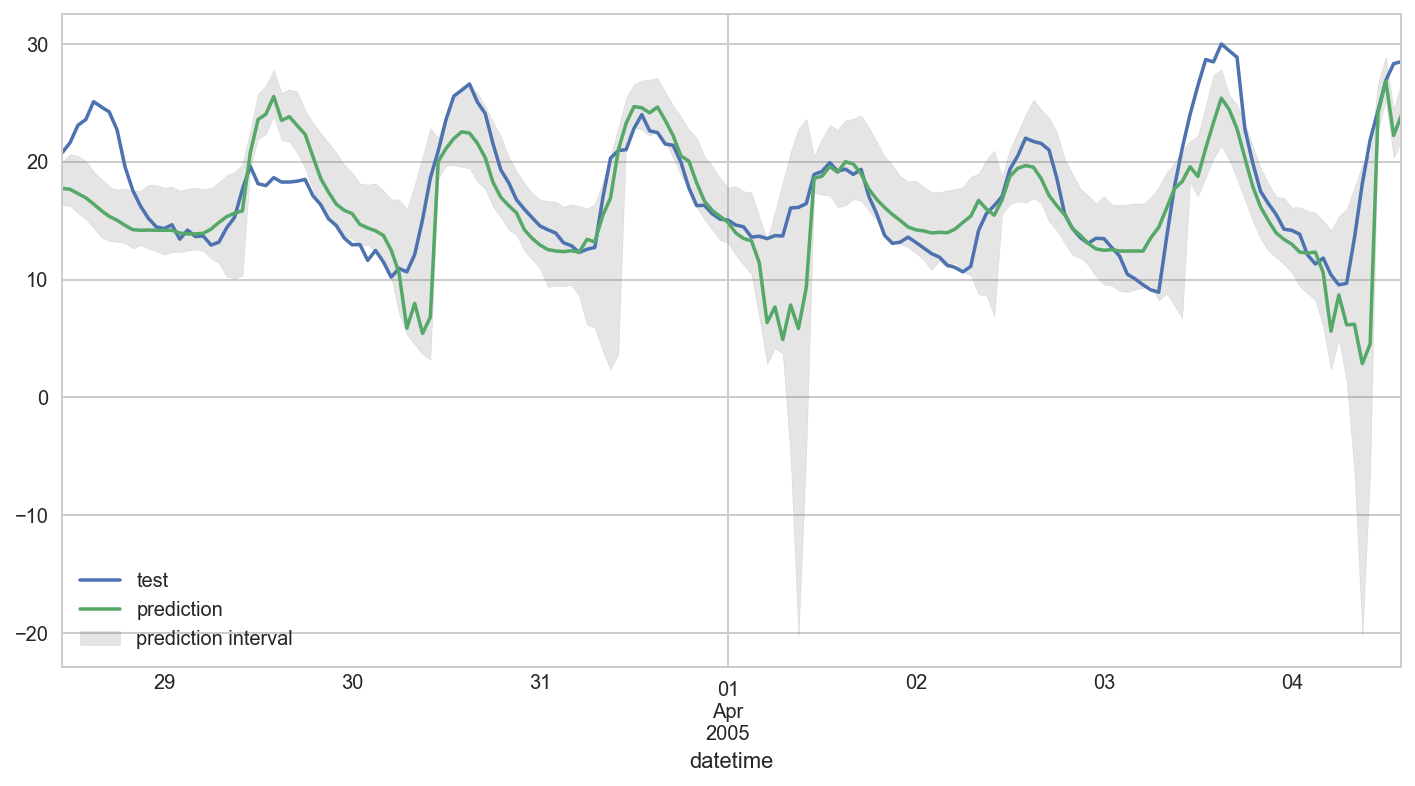

MSE:  15.731294752932119


In [64]:
plot_prediction(test.temp, pred_backtest)

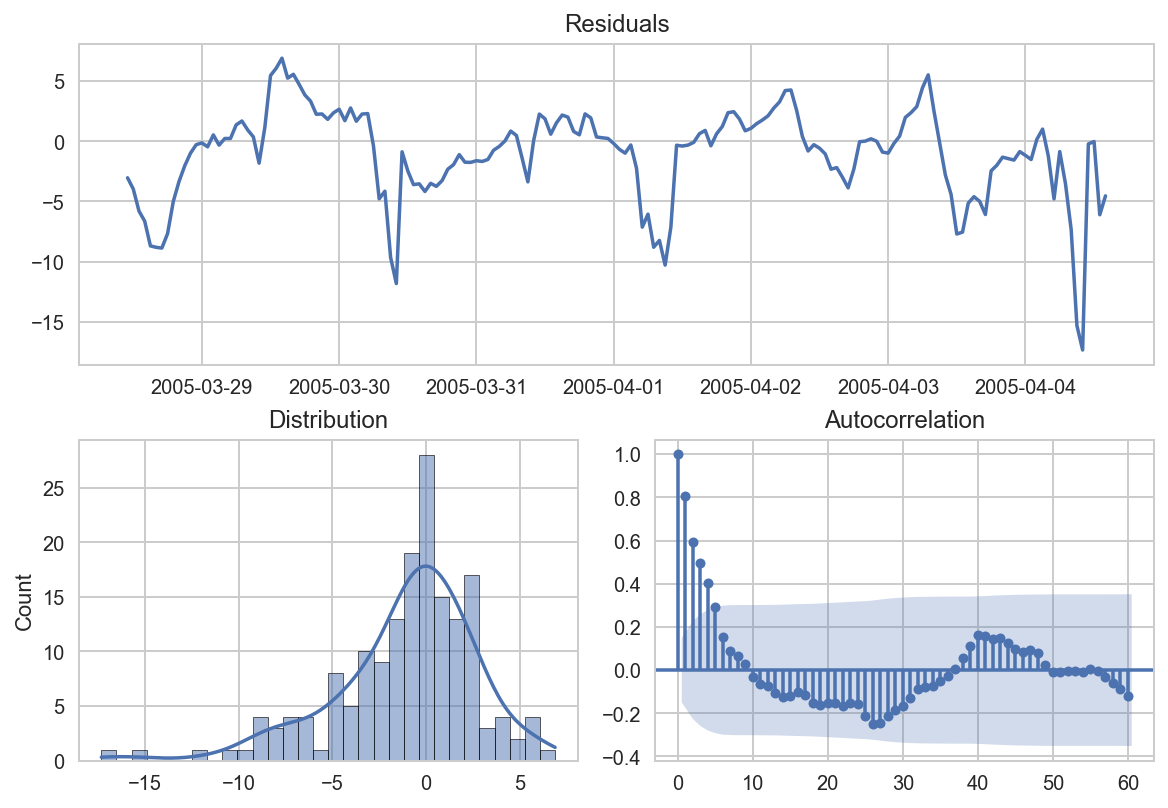

In [67]:
plot_residuals(y_true=test['temp'], y_pred=pred_backtest['pred'])

## 2.3. Hyperparameter tuning

### Grid search  

[GridSearch](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.grid_search_forecaster) and [RandomSearch](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.random_search_forecaster) has similar syntax

In [22]:
steps = len(test)
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=7),
                lags      = 24
             )

lags_grid = [12, 24, 48]

param_grid = {'n_estimators': [50, 100, 300],
              'learning_rate':[1e-2,1e-3],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = train['temp'],
                    exog        = train[['relativeHumidity','absoluteHumidity']],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 54.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}
  Backtesting metric: 15.987841871092568



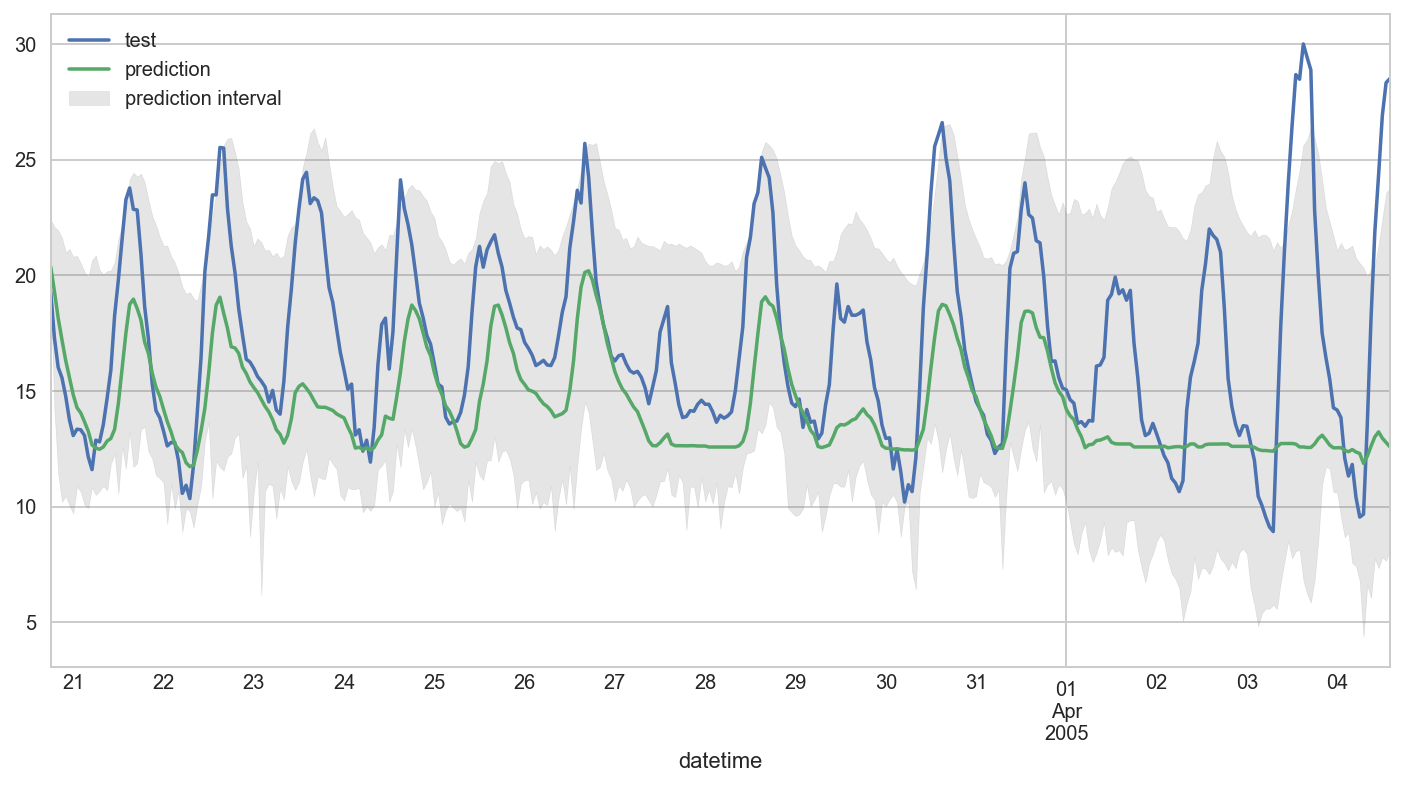

MSE:  20.44993243846528


In [23]:
pred_interval = forecaster.predict_interval(steps=steps, 
                                            exog=test[['relativeHumidity','absoluteHumidity']],
                                            interval = [5,95])

plot_prediction(test.temp, pred_interval)

### Bayesian search 

<code style='font-size:13px'><a href='https://joaquinamatrodrigo.github.io/skforecast/0.5.0/api/model_selection.html#skforecast.model_selection.model_selection.bayesian_search_forecaster'>bayesian_search_forecaster</a></code> supports *optuna* and *skpot* engine


In [24]:
from skforecast.model_selection import bayesian_search_forecaster

In [25]:
steps = len(test)
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=7),
                lags      = 24
             )

lags_grid = [12, 24, 48]

In [26]:
def search_space(trial):
    search_space = dict(
            n_estimators = trial.suggest_int('n_estimators', 300, 350),
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2),
            boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
            reg_alpha = trial.suggest_float('reg_alpha', 1e-3, 1e3, log=True),
            reg_lambda = trial.suggest_float('reg_lambda', 1e-3, 1e3, log=True),
        )
    return search_space

In [27]:
results, trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = train.temp,
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = steps,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 7,
                            return_best           = True,
                            verbose               = False,
                            engine                = 'optuna',
                            initial_train_size    = int(len(train)*0.5),
                            exog                  = train[['relativeHumidity','absoluteHumidity']],
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                        )

Number of models compared: 30,
         10 bayesian search in each lag configuration.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_estimators': 334, 'learning_rate': 0.09887304335154633, 'boosting_type': 'goss', 'reg_alpha': 0.7318244737414893, 'reg_lambda': 0.15679864837306304}
  Backtesting metric: 0.7225709810114573



In [28]:
print("Best param:",forecaster.regressor)

Best param: LGBMRegressor(boosting_type='goss', learning_rate=0.09887304335154633,
              n_estimators=334, random_state=7, reg_alpha=0.7318244737414893,
              reg_lambda=0.15679864837306304)


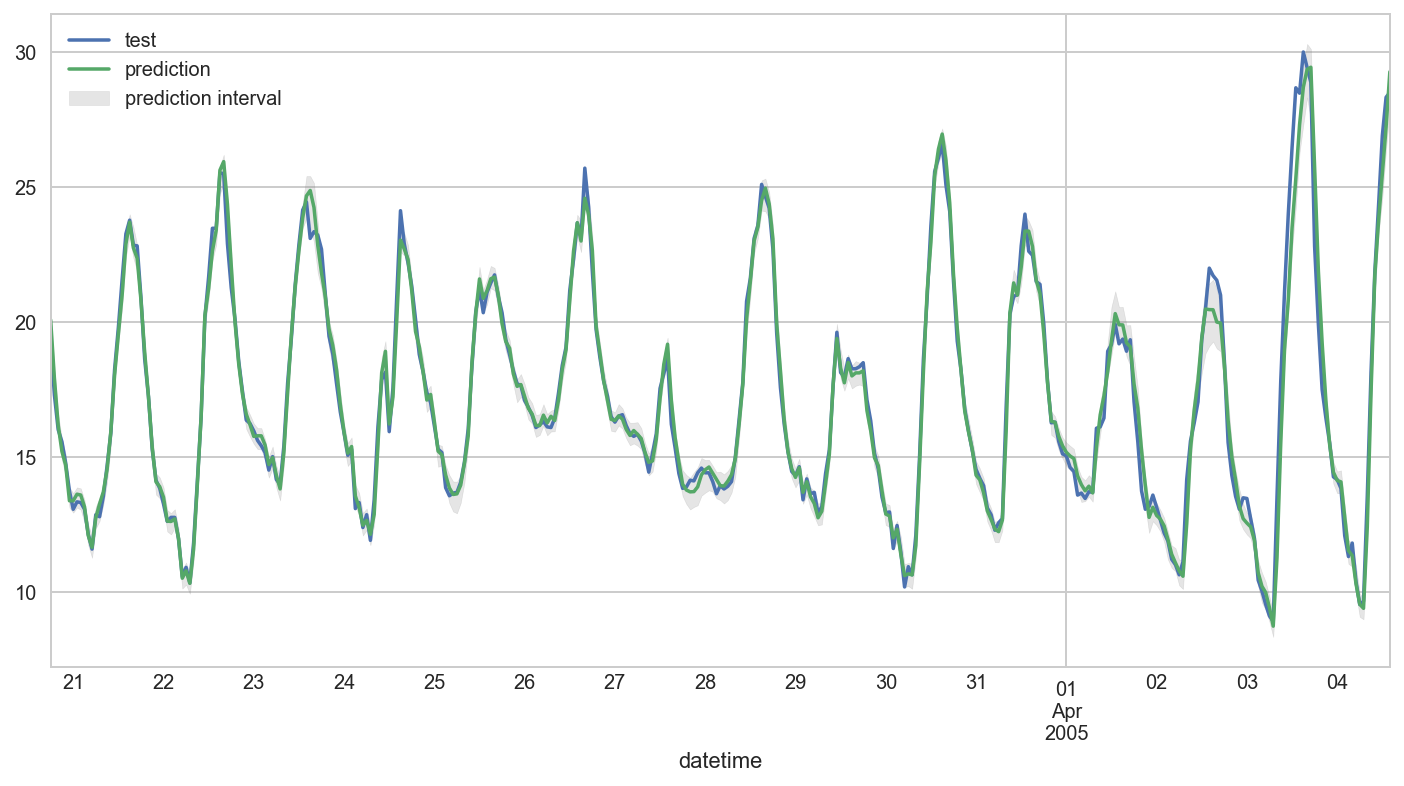

MSE:  0.3634550486831895


In [29]:
pred_interval = forecaster.predict_interval(steps=steps, exog=test[['relativeHumidity','absoluteHumidity']],
                                            interval=[5,95])

plot_prediction(test.temp, pred_interval)

# 5. AutoForecast
In this section, a class <code style='font-size:13px'>AutoForecast</code> combining different forecasting algorithms is developed. It automatically holds a validation set and can plots the results for diagnosis.

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from sspipe import p as f, px as p

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.tbats import TBATS

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

In [4]:
def format_number(num, decimal=2):
    power = 0
    while True:
        base = num / 10**power
        if 1e-3 <= np.abs(base) < 1e3: break
        elif np.abs(base) < 1e-3: power -= 3
        elif np.abs(base) >= 1e3: power += 3
    strBase = f'{base:.{decimal}f}'
    strPower = '' if power == 0 else f'e{power}'
    out = strBase + strPower
    return out

In [4]:
def grid_search_series(estimator, paramsGrid, sTrain, sTest):
    paramsGrid = ParameterGrid(paramsGrid)
    scoreBest = np.inf
    for params in paramsGrid:
        model = estimator(**params).fit(sTrain)
        sTestPred = model.predict(sTest.index)
        sTestPred[np.isnan(sTestPred)] = 0
        scoreTest = MSE(sTest, sTestPred, squared=False)
        if scoreBest > scoreTest:
            scoreBest = scoreTest
            modelBest = model
    return modelBest, scoreBest

In [5]:
def optimize_arima(sTrain, sTest, sp):
    model = AutoARIMA(
        test='kpss', sp=sp,
        start_p=0, max_p=2, start_q=0, max_q=2, d=0, max_d=2,
        start_P=0, max_P=2, start_Q=0, max_Q=2, D=0, max_D=2,
        suppress_warnings=True,
    )
    model = model.fit(sTrain)
    sTestPred = model.predict(fh=sTest.index)
    score = MSE(sTest, sTestPred, squared=False)
    return model, score

In [6]:
def optimize_ets(sTrain, sTest, sp):
    paramsGrid = {
        'error': ['add', 'mul'],
        'trend': ['add', 'mul'],
        'seasonal': ['add', 'mul'],
        'damped_trend': [True, False],
        'sp': [sp],
    }
    model, score = grid_search_series(AutoETS, paramsGrid, sTrain, sTest)
    return model, score

In [7]:
def optimize_tbats(sTrain, sTest, sp):
    paramsGrid = {
        'use_box_cox': [True, False],
        'use_trend': [True, False],
        'use_damped_trend': [True, False],
        'use_arma_errors': [True, False],
        'sp': [sp],
    }
    model, score = grid_search_series(TBATS, paramsGrid, sTrain, sTest)
    return model, score

In [8]:
def optimize_prophet(sTrain, sTest, sp):
    paramsGrid = {
        'daily_seasonality': [True],
        'yearly_seasonality': [True],
        'growth': ['linear'],
        'n_changepoints': [25],
        'changepoint_range': [0.8, 0.9],
        'seasonality_mode': ['multiplicative', 'additive'],
        'seasonality_prior_scale': [10],
        'changepoint_prior_scale': [0.05],
    }
    model, score = grid_search_series(Prophet, paramsGrid, sTrain, sTest)
    return model, score

In [9]:
class AutoForecast():
    def __init__(self, ts, estimator='ETS', nTest=7, sp=7, beginForecast=None, forcePositive=True): 
        self.series = ts
        self.estimator = estimator.upper()
        self.nTest = nTest
        self.sp = sp
        self.beginForecast = beginForecast
        self.forcePositive = forcePositive
        
        sSeen = self.series[:beginForecast]
        self.sTrain = sSeen[:-nTest]
        self.sTest = sSeen[-nTest:]
        self.fhTest = np.arange(1, self.nTest + 1)
        
        start = dt.datetime.now()
        
        if 'ARIMA' in self.estimator:
            self.model, _ = optimize_arima(self.sTrain, self.sTest, self.sp)
        if 'ETS' in self.estimator or 'HOLT' in self.estimator:
            self.model, _ = optimize_ets(self.sTrain, self.sTest, self.sp)
        if 'TBATS' in self.estimator:
            self.model, _ = optimize_tbats(self.sTrain, self.sTest, self.sp)
        if 'PROPHET' in self.estimator:
            self.model, _ = optimize_prophet(self.sTrain, self.sTest, self.sp) 
                    
        print(dt.datetime.now() - start)
        
    
    def get_forecast(self, nInfer=7, nHistory=0, gamma=(0.95, 0.99)):
        start = 1 - nHistory 
        end = 1 + self.nTest + nInfer
        fhInfer = np.arange(start, end)
        dfCi = self.model.predict_interval(fhInfer, coverage=gamma)
        if self.forcePositive:
            dfCi = dfCi.clip(lower=0)
        dfCi.columns = [f'{bound}_{int(ci*100)}' for ci in gamma for bound in ['lower', 'upper']]
        dfForecast = self.model.predict(fhInfer).rename('forecast').to_frame()
        dfForecast = dfForecast.join(dfCi)
        dfForecast = dfForecast.join(self.series.rename('truth'))
        # dfForecast['run_date'] = dt.date.today()
        return dfForecast
    
    def plot_forecast(self, nInfer=7, nHistory=0, gamma=(0.95, 0.99)):
        sTestPred = self.model.predict(self.fhTest)
        rmse = MSE(self.sTest, sTestPred, squared=False) | f(format_number)
        mae = MAE(self.sTest, sTestPred) | f(format_number)
        r2 = R2(self.sTest, sTestPred) | f(format_number)
        try: 
            modelDetail = self.model.summary().tables[0][1][1].data
        except:
            modelDetail = self.estimator
        title = f'{modelDetail} | RMSE={rmse} | MAE={mae} | R2={r2}'
        
        dfForecast = self.get_forecast(nInfer, nHistory, gamma)

        fig, ax = plt.subplots(figsize=(18,6))
        if nHistory > 0:
            dfForecast.truth[:nHistory].plot(color='black', label='True, seen, fitted')
            dfForecast.truth[nHistory-1:nHistory+self.nTest].plot(color='lightseagreen', label='True, seen, not fitted')
            dfForecast.truth[nHistory+self.nTest-1:].plot(color='indianred', label='True, not seen')
            dfForecast.forecast.plot(style='--', c='grey', label='Forecast')
        else:
            dfForecast.truth[:self.nTest].plot(color='lightseagreen', label='True, seen, not fitted')
            dfForecast.truth[self.nTest-1:].plot(color='indianred', label='True, not seen')
            dfForecast.forecast.plot(style='--', c='grey', label='Forecast')
        
        if self.beginForecast is not None:
            ax.axvline(x=dfForecast.index[nHistory+self.nTest-1], ls=':', c='indianred')
        if nHistory > 0:
            ax.axvline(x=dfForecast.index[nHistory-1], ls=':', c='lightseagreen')
            
        for ci in gamma:
            opacity = 1 - ci + 0.05
            strCi = int(ci*100)
            lower, upper = dfForecast[f'lower_{strCi}'], dfForecast[f'upper_{strCi}']
            ax.fill_between(dfForecast.index, lower, upper, color='grey', alpha=opacity, label=f'CI {strCi}%')
        ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
        ax.set_title(title, fontsize=14)
        plt.show()

In [26]:
dfQty = pd.read_csv('data/weekly_quantity.csv')
dfQty['date'] = dfQty['date'].astype('datetime64')
dfQty = dfQty.set_index('date')
dfQty = dfQty.asfreq('d')
sQty = dfQty.quantity

sTrain = sQty[:-7]
sTest = sQty[-7:]

0:00:02.654598


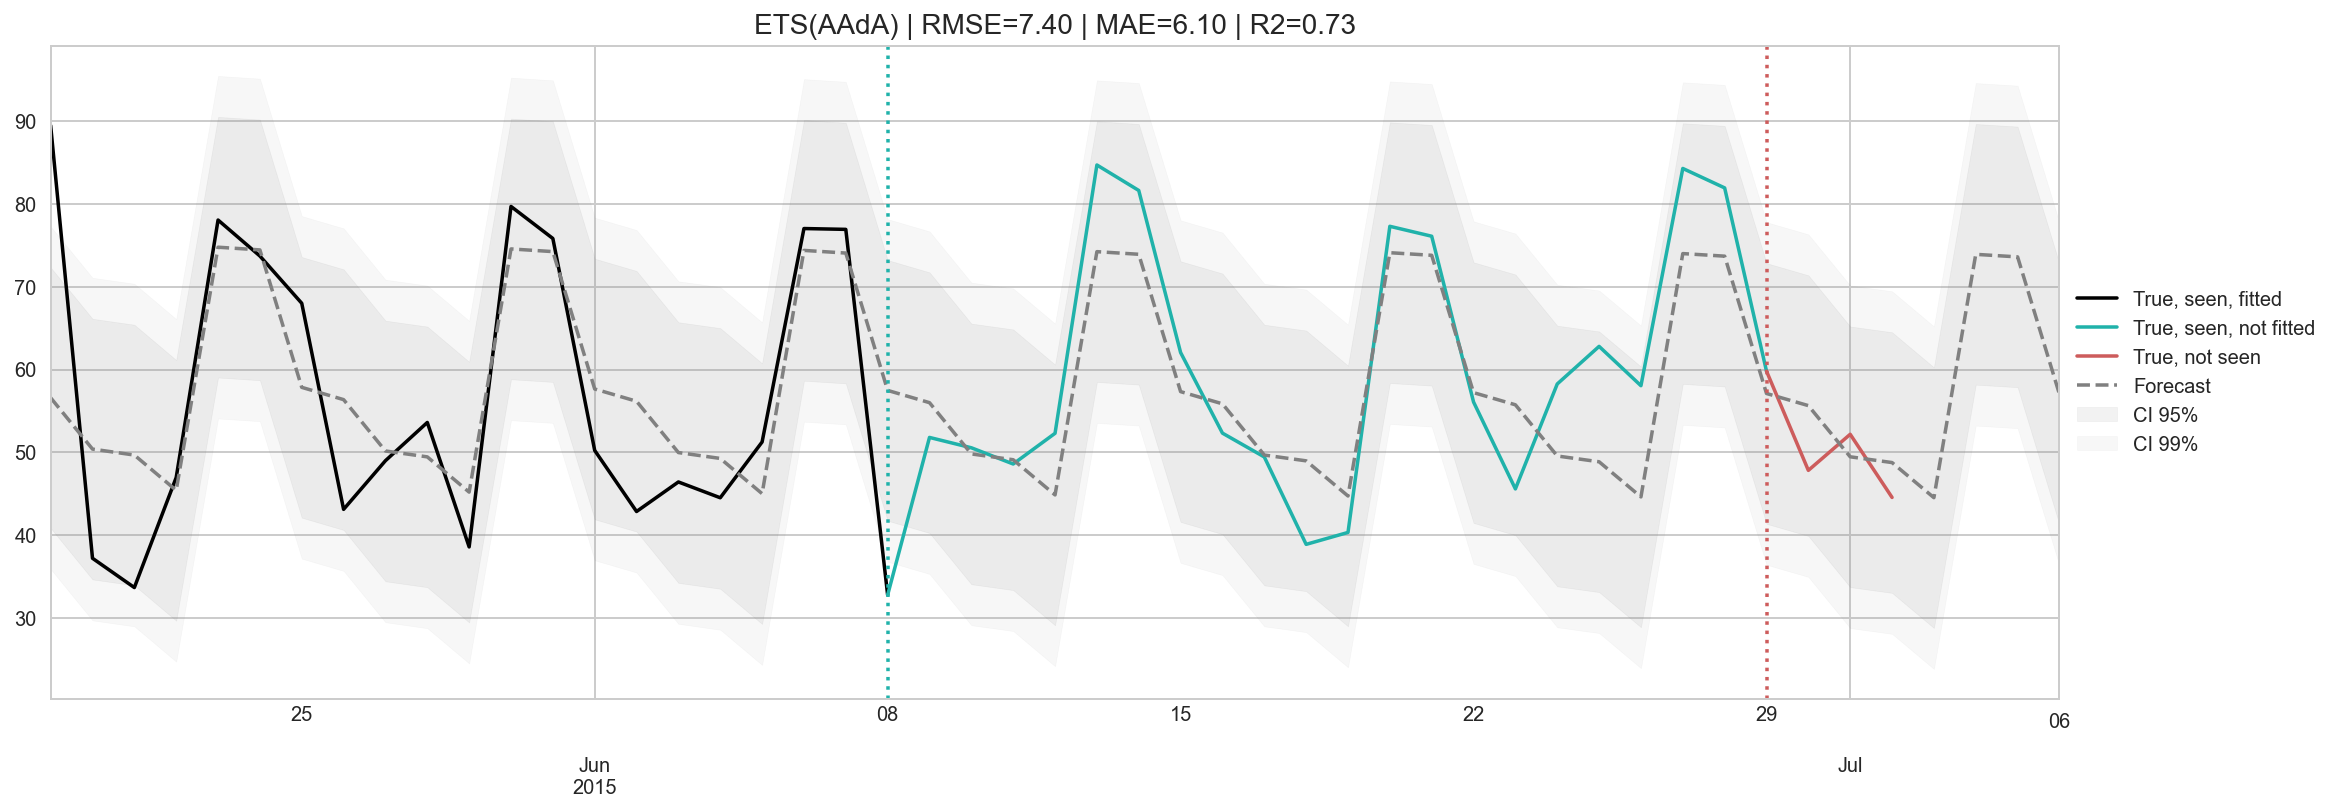

In [27]:
model = AutoForecast(sQty, estimator='ets', beginForecast='2015-06-29', nTest=7*3, sp=7)
model.plot_forecast(nInfer=7, nHistory=7*3)

# References
- *skforecast - [Skforecast documentation](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/index.html)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*